## Robust category recognition based on deep templates for educational mobile applications

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.utils import to_categorical

# libraries required for the transfer learning with pre-trained models 
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications import ResNet50


# libraries required for the transfer learning with pre-trained models 
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as Pre_input_MN
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as Pre_input_EF
from tensorflow.keras.applications.resnet import preprocess_input as Pre_input_RS

# data visualization and testing:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns


# similarity/distance measures:
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances
from sklearn.metrics import DistanceMetric

In [2]:
# we define a dictionary that can be used to map a folder name with specific class data.
# to the desired labels, we used a dumb definition: 
class_dictionary = {0: "zebra", 1: "Uszatek", 2: "teddy", 3: "boat", 4: "dozer", 5: "bear"}
def decode_predictions(array, class_dictionary):
    return np.array(list(map(class_dictionary.get, array)))

In [3]:
class_dictionary.values()

dict_values(['zebra', 'Uszatek', 'teddy', 'boat', 'dozer', 'bear'])

# Templates creation

In [4]:
# the selection of the number of samples to create templates 
# is done manually according to the following scheme: 
# for 1 sample: Dataset_N1/train, 
# for 2 samples: Dataset_N2/train, 
# for 3 samples: Dataset_N3/train,
# for 4 samples: Dataset_N4/train, 
# for 5 samples: Dataset_N5/train, 
# for 10 samples: Dataset_N10/train,
# for 20 samples: Dataset_N20/train.

path_train = "Dataset_N20/train"


# the selection of the test set
# is done manually according to the following scheme: 
# for 1 sample: Dataset_N1/test, 
# for 2 samples: Dataset_N2/test, 
# for 3 samples: Dataset_N3/test,
# for 4 samples: Dataset_N4/test, 
# for 5 samples: Dataset_N5/test, 
# for 10 samples: Dataset_N10/test,
# for 20 samples: Dataset_N20/test.


path_test = "Dataset_N20/test"


# ensure that the number of saplems in both selected paths to foilders always matches.


In [5]:
# reading data from a folder with a single example (used to create representations of categories). 
# preprocess_input is a function given by keras for a particualr model or a custiom fuction that prepares data for the model 
image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_train,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)



Found 120 files belonging to 6 classes.


# Creation of transfer learning models 

#### model_MN is based on MobileNetV2 - details of this model can be found on https://keras.io/api/applications/mobilenet/#mobilenetv2-function

In [6]:
model_MN = MobileNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling='avg',
    classes=1000,
    classifier_activation="softmax"
)
# creating a model without the top layer 
inter_output_model_MN = tf.keras.Model(inputs=model_MN.input,
                           outputs=model_MN.layers[-2].output)



#### model_EF is based on EfficientNetV2B0 - details of this model can be found on https://keras.io/api/applications/efficientnet_v2/#efficientnetv2b0-function

In [7]:
model_EF = EfficientNetV2B0(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling='avg',
    classes=1000,
    classifier_activation="softmax",
)

# creating a model without the top layer 

inter_output_model_EF = tf.keras.Model(inputs=model_EF.input,
                           outputs=model_EF.layers[-2].output)

#### model_RN is based on ResNetV2 - details of this model can be found on https://keras.io/api/applications/resnet/#resnet50v2-function

In [27]:
model_RN = ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling='avg',
    classes=1000,
    classifier_activation="softmax",
)

# creating a model without the top layer 
inter_output_model_RN = tf.keras.Model(inputs=model_RN.input, 
                            outputs=model_RN.layers[-2].output)

In [28]:
# to create a raw template, select one of the three available pre-trained models:
# MobileNetV2 > inter_output_model_MN
# EfficientNetV2B0 > inter_output_model_EF
# ResNetV2 > inter_output_model_RN

inter_output_model = inter_output_model_MN



# checking which pre-tested model is used in the experiment 
# and applying the appropriate pre-processing function for it 

if inter_output_model == inter_output_model_MN:
    model = "MobileNetV2" 
    normalized_ds_train = train_ds.map(lambda x, y: (Pre_input_MN(x), y))
elif inter_output_model == inter_output_model_EF:
    model = "EfficientNetV2B0" 
    normalized_ds_train = train_ds.map(lambda x, y: (Pre_input_EF(x), y))
if inter_output_model == inter_output_model_RN:
    model = "ResNetV2" 
    normalized_ds_train = train_ds.map(lambda x, y: (Pre_input_RS(x), y))



In [ ]:
Y_train = np.concatenate(np.array([y for x, y in normalized_ds_train]), axis=0) 
X_train = np.concatenate(np.array([x for x, y in normalized_ds_train]), axis=0) 

In [30]:

templates_raw = inter_output_model.predict(X_train)

4/4 [==============================] - 3s 411ms/step


In [31]:
# analysis of change in number of images in train_ds
# n_images_for_templates must match the number of samples declared path
# e.g. for path = "Dataset_N5/train", then n_images_for_templates = 5.


n_images_for_templates = 20
templates = np.average(templates_raw.reshape(int(templates_raw.shape[0] / n_images_for_templates), n_images_for_templates ,templates_raw.shape[1]), axis=1)

# Testing

### Creation of a test set

In [32]:
# we use shuffle false to have the original order of data

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_test,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)


Found 1680 files belonging to 6 classes.


In [33]:
# checking which pre-tested model is used in the experiment 
# and applying the appropriate pre-processing function for it 

if inter_output_model == inter_output_model_MN:
    normalized_ds_test = test_ds.map(lambda x, y: (Pre_input_MN(x), y))
elif inter_output_model == inter_output_model_EF:
    normalized_ds_test = test_ds.map(lambda x, y: (Pre_input_EF(x), y))
if inter_output_model == inter_output_model_RN:
    normalized_ds_test = test_ds.map(lambda x, y: (Pre_input_RS(x), y))

In [ ]:
Y_test = np.concatenate(np.array([y for x, y in normalized_ds_test]), axis=0) 
X_test = np.concatenate(np.array([x for x, y in normalized_ds_test]), axis=0) 

In [35]:
test_pred = inter_output_model.predict(X_test)

53/53 [==============================] - 23s 434ms/step


### Distance/similarity measures implementation


In [36]:
# implementation of Jaccard Similarity and Jaccard Distance
def jaccard_similarity(X, Y):
    def jaccard(a,b):
        return (np.sum(a*b, axis=0)) / ((np.sqrt(np.sum(a ** 2, axis=0))) ** 2 + \
                                        (np.sqrt(np.sum(b ** 2, axis=0))) ** 2 - (np.sum(a*b, axis=0)))
    jacard_dist = np.zeros((X.shape[0], Y.shape[0]))
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            jacard_dist[i][j] = jaccard(X[i],Y[j])
    return jacard_dist


In [37]:
# defining distance metric with scikit-learn
euclidean = DistanceMetric.get_metric('euclidean')
manhattan = DistanceMetric.get_metric('manhattan')
chebyshev = DistanceMetric.get_metric('chebyshev')
minkowski =  DistanceMetric.get_metric('minkowski')

In [38]:
# selection of the available method (metric/distance similarity) 
# from among the available following: 
# Euclidean distance metric > "MSE",
# Manhattan distance metric > "MAE",
# Chebyshev distance metric > "CBE",
# Minkowski distance metric > "MINK",
# Jaccard Similarity > "Jaccard",
# Cosine Similarity > "CCosine".
# the method_name variable requires one of the above 

method_name = "COS"

In [39]:
def predict_category(prediction, templates, method=method_name):
    # function that can be used to return a category
    if method == "MSE":
        results = np.argmin(euclidean_distances(templates, prediction), axis = 0)
    elif method == "MAE":
        results = np.argmin(manhattan_distances(templates, prediction), axis = 0)
    elif method == "CBE":
        results = np.argmin(chebyshev.pairwise(templates, prediction), axis = 0)
    elif method == "MINK":
        results = np.argmin(minkowski.pairwise(templates, prediction), axis = 0)
    elif method == "Jaccard":
        results = np.argmax(jaccard_similarity(templates, prediction), axis = 0)
    else:
        results = np.argmax(cosine_similarity(templates, prediction), axis = 0) 
    return results

In [40]:
# example usage (takes a batch as an input):
predictions = predict_category(test_pred, templates, method=method_name)

In [41]:
# example usage (takes a batch with a single sample as an input):
single_prediction = predict_category(np.expand_dims(test_pred[0], axis=0), templates, method=method_name)

# Evaluation

In [42]:
acc = accuracy_score(np.argmax(Y_test, axis=1), predictions)

In [43]:
# the accuracy of a specific model is displayed, 
# along with additional information on the number of samples used and the method name. 

print(f"The accuracy of model {model} is: {acc}, for numbers of samples equile {n_images_for_templates} "
f"crating to tamples, involving {method_name}.")

The accuracy of model MobileNetV2 is: 0.9744047619047619, for numbers of samples equile 20 crating to tamples, involving COS.


#### visualization of results 

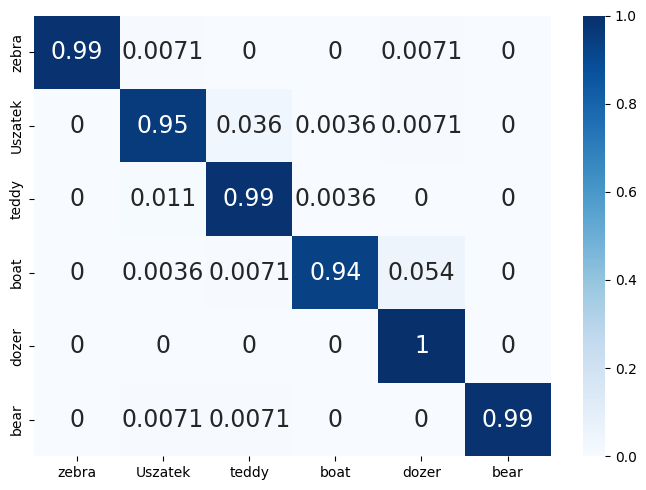

In [44]:
# creating a heatmap visualization of a normalized confusion matrix

confusion_matrix_normalize = confusion_matrix(np.argmax(Y_test, axis=1), predictions, normalize='true')

plt.figure(figsize=(7,5))
ax = sns.heatmap(confusion_matrix_normalize, annot=True, cmap='Blues', annot_kws={"size": 17})
ax.set_yticklabels(["zebra","Uszatek", "teddy","boat", "dozer", "bear"], va='center')
ax.set_xticklabels(["zebra","Uszatek", "teddy","boat", "dozer", "bear"])

plt.tight_layout()
plt.show()

# Testing the performance under rotation

In [45]:
# copying the test data for processing
XX_test = X_test.copy()
# performing a rotation on the test data and repeating the prediction and evaluation process
pred = inter_output_model.predict(XX_test)
prediction = predict_category(pred, templates, method="Cosine")
print(prediction)
print(decode_predictions(prediction, class_dictionary))
print()
print(f"accuracy: {accuracy_score(np.argmax(Y_test, axis=1), prediction)}")
print()
print()
for i in range(3):
    XX_test = np.rot90(XX_test, axes=(1,2))
    pred = inter_output_model.predict(XX_test)
    prediction = predict_category(pred, templates, method="Cosine")
    print(prediction)
    print(decode_predictions(prediction, class_dictionary))
    print()
    print(f"accuracy: {accuracy_score(np.argmax(Y_test, axis=1), prediction)}")
    print()
    print()

53/53 [==============================] - 22s 419ms/step
[0 0 0 ... 5 5 5]
['zebra' 'zebra' 'zebra' ... 'bear' 'bear' 'bear']

accuracy: 0.9744047619047619


53/53 [==============================] - 23s 425ms/step
[0 0 0 ... 5 5 5]
['zebra' 'zebra' 'zebra' ... 'bear' 'bear' 'bear']

accuracy: 0.9744047619047619


53/53 [==============================] - 24s 447ms/step
[0 0 0 ... 5 5 5]
['zebra' 'zebra' 'zebra' ... 'bear' 'bear' 'bear']

accuracy: 0.9714285714285714


53/53 [==============================] - 28s 534ms/step
[0 0 0 ... 5 5 5]
['zebra' 'zebra' 'zebra' ... 'bear' 'bear' 'bear']

accuracy: 0.9767857142857143


